# Disclaimer

This does not work because voarchive.asu.cas.cz fall down after some
number of requests.

# Try It

http://docs.astropy.org/en/stable/vo/ library should be tried.

# Simple Spectral Access protocol

SSAP, SSA defines a uniform intreface to remotely discover
and access one dimenisonal spectra. Spectral data access
mmay involve active transformation of data. SSA also
defines complete metadata to describe the available
datasets. It makes use of VOTable for metadata exchange.

## Architecture

A query is used for data discovery and to negotiate the
details of the static or dynamically created dataset
to be retrieved. SSA allows to mediate not only dataset
metadata but the actual dataset itself. Direct access to
data is also provided.

A single service may support multiple operation to perform
various functions. The current interface use an HTTP GET
request to submit parametrized requests with responses
being returned as for example FITS or VOTable. Defined
operations are the following:

1. A queryData operation return a VOTable describing
candidate datasets.
2. A getData operation is used to access an individual
dataset.

## Basic Usage

In [1]:
import urllib.request
import urllib.parse
import io
import os
import glob
from functools import partial
from itertools import count
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline
import xml.etree.ElementTree as ET
import numpy as np

In [2]:
def make_ssap_url(
    band,
    request='queryData',
    file_format='votable',
    maxrec=10 ** 6,
    url_parameters={},
    url='http://voarchive.asu.cas.cz/ccd700/q/ssa/ssap.xml',
):
    url_parameters['BAND'] = str(band)
    url_parameters['REQUEST'] = request
    url_parameters['FORMAT'] = file_format
    url_parameters['MAXREC'] = maxrec
    return url + '?' + urllib.parse.urlencode(url_parameters)

ssap_url = make_ssap_url(band=6562e-10)
ssap_url

'http://voarchive.asu.cas.cz/ccd700/q/ssa/ssap.xml?BAND=6.562e-07&FORMAT=votable&MAXREC=1000000&REQUEST=queryData'

In [3]:
def request_url(url):
    with urllib.request.urlopen(url) as response:
         data = response.read()
    return data

ssap_xml = request_url(ssap_url)
type(ssap_xml)

bytes

## XML Parsing

In [4]:
root = ET.fromstring(ssap_xml)
root, root.tag, root.attrib

(<Element '{http://www.ivoa.net/xml/VOTable/v1.2}VOTABLE' at 0x7f28c724b1d8>,
 '{http://www.ivoa.net/xml/VOTable/v1.2}VOTABLE',
 {'version': '1.2',
  '{http://www.w3.org/2001/XMLSchema-instance}schemaLocation': 'http://www.ivoa.net/xml/VOTable/v1.2 http://vo.ari.uni-heidelberg.de/docs/schemata/VOTable-1.2.xsd'})

In [5]:
def get_ids(root):
    # first RESOURCE
    # last TABLE
    # last DATA
    # first TABLEDATA
    # eleventh ID
    return (c[11].text for c in root[0][-1][-1][0])
    
spectra_pub_ids = set(get_ids(root))
len(spectra_pub_ids)

13431

In [6]:
def make_datalink_url(
    pub_id,
    fluxcalib,
    lambda_min,
    lambda_max,
    file_format='application/fits',
    url_parameters={},
    url='http://voarchive.asu.cas.cz/ccd700/q/sdl/dlget'
):
    url_parameters['ID'] = pub_id
    if fluxcalib:
        url_parameters['FLUXCALIB'] = fluxcalib
    url_parameters['LAMBDA_MIN'] = str(lambda_min)
    url_parameters['LAMBDA_MAX'] = str(lambda_max)
    url_parameters['FORMAT'] = file_format
    return url + '?' + urllib.parse.urlencode(url_parameters)

datalink_url = make_datalink_url(
    'ivo://asu.cas.cz/stel/ccd700/sh270028',
    fluxcalib='relative',
    lambda_min=6500e-10,
    lambda_max=6600e-10
)
datalink_url

'http://voarchive.asu.cas.cz/ccd700/q/sdl/dlget?LAMBDA_MIN=6.5e-07&FORMAT=application%2Ffits&LAMBDA_MAX=6.6e-07&FLUXCALIB=relative&ID=ivo%3A%2F%2Fasu.cas.cz%2Fstel%2Fccd700%2Fsh270028'

In [11]:
def ondrejov_fits(fluxcalib=None):
    datalink_url = make_datalink_url(
        'ivo://asu.cas.cz/stel/ccd700/kk150018',
        fluxcalib=fluxcalib,
        lambda_min=6282e-10,
        lambda_max=6733e-10
    )
    fits_data = request_url(datalink_url)
    hdulist = fits.open(io.BytesIO(fits_data))
    plt.plot(hdulist[1].data['spectral'], hdulist[1].data['flux'])

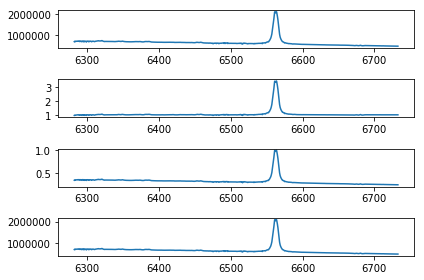

In [12]:
plt.subplot(4, 1, 1)
ondrejov_fits()
plt.subplot(4, 1, 2)
ondrejov_fits('normalized')
plt.subplot(4, 1, 3)
ondrejov_fits('relative')
plt.subplot(4, 1, 4)
ondrejov_fits('UNCALIBRATED')
plt.tight_layout()

# FITS Download

In [22]:
def download_spectrum(pub_id, n, directory, fluxcalibration, minimum, maximum):
    name = pub_id.split('/')[-1]
    path = os.path.join(directory, name + '.fits')
    url = make_datalink_url(pub_id, fluxcalibration, minimum, maximum)
    print('{:5} downloading {}'.format(n, name))
    try:
        data = request_url(url)
    except Exception as e:
        print(e)
        return name
    with open(path, 'wb') as f:
        f.write(data)

In [26]:
fits_directory = 'ssap'
%mkdir $fits_directory 2> /dev/null

ondrejov_downloader = partial(
    download_spectrum,
    directory=fits_directory,
    fluxcalibration='normalized',
    minimum=6282e-10,
    maximum=6733e-10,
)

In [21]:
def get_pub_id(path):
    return 'ivo://asu.cas.cz/stel/ccd700/' + os.path.splitext(os.path.split(path)[-1])[0]

get_pub_id('ssap/uh260033.fits')

'ivo://asu.cas.cz/stel/ccd700/uh260033'

In [27]:
spectra_pub_ids -= set(map(get_pub_id, glob.glob(os.path.join('ssap', '*.fits'))))
print(len(spectra_pub_ids))
donwload_info = list(map(ondrejov_downloader, spectra_pub_ids, count(start=1)))

12258
    1 downloading a201603280012
HTTP Error 500: Internal Server Error
    2 downloading uj150031
HTTP Error 500: Internal Server Error
    3 downloading a201306180023
HTTP Error 500: Internal Server Error
    4 downloading pj180027
HTTP Error 500: Internal Server Error
    5 downloading vd300048
HTTP Error 500: Internal Server Error
    6 downloading a201409180031
HTTP Error 500: Internal Server Error
    7 downloading tc240030
HTTP Error 500: Internal Server Error
    8 downloading sc210026
HTTP Error 500: Internal Server Error
    9 downloading oi060021
HTTP Error 500: Internal Server Error
   10 downloading mk080012
HTTP Error 500: Internal Server Error
   11 downloading rg070008
HTTP Error 500: Internal Server Error
   12 downloading pg020022
HTTP Error 500: Internal Server Error
   13 downloading vl300044
HTTP Error 500: Internal Server Error
   14 downloading a201309280024
HTTP Error 500: Internal Server Error
   15 downloading uc010035


KeyboardInterrupt: 